# Multivariate Linear Regression
## Predicting House Price from Size and Number of Bedrooms

This exercise is modified from the source: https://github.com/kaustubholpadkar/Predicting-House-Price-using-Multivariate-Linear-Regression

### Import Libraries

In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

### Read the House Data

NumPy provides the `genfromtxt()` function to load data from a text file into an array. As usual, each row in that file represents a different data point, observation, or example. Its components are separated by commas, so we set the `delimiter` parameter in `genfromtxt()`'s argument list to `','`.

In [2]:
data = np.genfromtxt('https://raw.githubusercontent.com/Tan-Moy/medium_articles/master/art2_multivariate_linear_regression/home.txt', delimiter=',')

Examine the data's shape with the convenient `.shape` attribute. NumPy arrays and structures based on them all have it.

In [3]:
data.shape

(47, 3)

By convention, the last element in an array's `.shape` tuple refers to its number of columns. Our dataset thus has 47 rows and 3 columns. 

Let's visually inspect the first 5 rows of the data

In [4]:
data[:5, :]

array([[2.104e+03, 3.000e+00, 3.999e+05],
       [1.600e+03, 3.000e+00, 3.299e+05],
       [2.400e+03, 3.000e+00, 3.690e+05],
       [1.416e+03, 2.000e+00, 2.320e+05],
       [3.000e+03, 4.000e+00, 5.399e+05]])

The columns from left to right indicate each house's:

0.   Floor area in square feet
1.   Number of bedrooms
2.   Price in dollars

The first 2 are our features, i.e. the attributes of the data which we feed into our model to make predictions. The last is our target, the value which we're attempting to predict. 

### Normalize Data

Normalization of feature (and for regression problems, target) columns can  mitigate problems that can arise from loss function gradients becoming too large or small, and thus help a model converge faster. There are several ways to normalize data. Here, we're going to rescale each column so that its L2 norm is 1, i.e. the sum of the squares of each element in a given column will be 1. 

We'll use the `normalize()` function from scikit-learn's preprocessing module. We'll need to specify the array axis along which we'll be calculating our norms. For aggregating functions (functions like mean and standard deviation) in NumPy and related libraries, the `axis` (or in the case of PyTorch, `dim`) parameter refers to the axis along which the aggregation is performed. Our data is a 2D array. We want to normalize each column, which means that within a given column, we aggregate the numbers from each row. For a 2D array, the 0 axis corresponds to the rows and the 1 axis corresponds to the columns. Thus, we pass `axis=0` into our call to the `normalize()` function.

In [5]:
data = normalize(data, axis=0)

Let's inspect the first 5 rows of our data again.

In [6]:
data[:5, :]

array([[0.14276982, 0.13429844, 0.16105104],
       [0.10857021, 0.13429844, 0.13286006],
       [0.16285531, 0.13429844, 0.14860674],
       [0.09608463, 0.0895323 , 0.09343296],
       [0.20356914, 0.17906459, 0.217433  ]])

The numbers look quite different from before. The floor areas, which were in square feet and on the order of $10^{3}$, are now represented by normalized figures on the order of $10^{-1}$ or just below. Similarly, the prices have been reduced from dollar figures on the order of $10^{5}$.

Let's verify that the `normalize()` function did its job properly

In [7]:
# Floor area column
np.sum(np.square(data[:,0]))

1.0000000000000002

In [8]:
# Bedroom count column
np.sum(np.square(data[:,1]))

1.0

In [9]:
# Price column
np.sum(np.square(data[:,2]))

1.0

To within a roundoff error, our data has, indeed, been normalized properly.

### Separate Data into X and Y

I.e., separate the target from the features 

In [10]:
X = data[:, 0:2]
Y = data[:, 2:]

### Visualize the Data

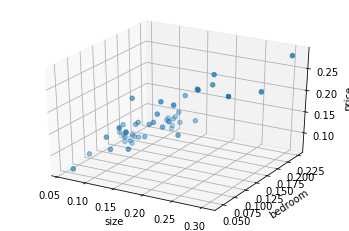

In [11]:
# Fixing random state for reproducibility
np.random.seed(19680801)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = X[:, 0]
ys = X[:, 1]
zs = Y
ax.scatter(xs, ys, zs)

ax.set_xlabel('size')
ax.set_ylabel('bedroom')
ax.set_zlabel('price')

plt.show()

It appears that our data points are distributed closely to a 2D plane. Multivariate linear regression should give us reasonable price predictions.

Now that we've explored our data, let's prepare the model.

### Hyperparameters

First, let's choose the hyperparameters (which the model won't learn, but which will influence the model's outcome and performance). **In most machine learning problems, the objective is to learn the values of parameters** (which interact with the features of any data point/observation/example fed into the model) **such that a loss function** (a penalty for predictions in the training data not matching their ground truth values) **is minimized**. One typically uses numerical approximations of gradients of this loss function to minimize it. 

The three most common methods for updating the loss function gradients and learned parameters are: 

1.   Batch gradient descent - Each update uses the entire dataset
2.   Stochastic gradient descent - The gradients and parameters are updated after every training example
3.   Mini-batch gradient descent - Something in between batch and stochastic gradient descent: The model reads in a subset of the full dataset before updating the gradients and parameters. Mini-batch sizes in powers of 2 are preferable. 

In [12]:
# Batch gradient descent
learning_rate = 0.09
max_iteration = 500

In [13]:
# Stochastic gradient descent
s_learning_rate = 0.06
s_max_iteration = 500

In [14]:
# Mini-Batch gradient descent
mb_learning_rate = 0.09
mb_max_iteration = 500
batch_size = 16

### Exercise: Parameters

Initialize the arrays of theta parameters (one for each of the gradient descent methods above) which 2D arrays of zeros. Each row should correspond to a feature (column of `X`), with a bias term added (which will allow us to move our plane up or down the price, i.e. z axis). There should only be one element per row. 

You may find this function useful: [np.zeros()](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)

In [15]:
### START CODE HERE ###
theta = np.zeros((X.shape[1]+1, 1))
s_theta = np.zeros((X.shape[1]+1, 1))
mb_theta = np.zeros((X.shape[1]+1, 1))
### END CODE HERE ###

### Exercise: Hypothesis

Define a function which adds a column of ones (to complement the offset/bias parameter) to the features `X` of the dataset and computes a matrix multiplication between it and an array of learned parameters `theta`. Pay attention to the shapes of `X` and `theta`; matrix multiplication is not commutative. 

More generally, a hypothesis function `h` takes in features `X` and learned parameters `theta` to make a prediction, commonly denoted $\hat{Y}$. The loss function (which you'll implement in the code cell immediately following the one for the hypothesis function) is a measure of the difference between your model's predicted target values and actual, ground truth target values. 

You may find these functions useful: [np.ones()](https://numpy.org/doc/stable/reference/generated/numpy.ones.html), [np.dot()](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [np.matmul()](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) 

In [16]:
def h(theta, X) :
    ### START CODE HERE ###
    # Add a 0th column of ones to X
    tempX = np.hstack((np.ones((X.shape[0],1)), X))
    # Return a matrix multiplication of your augmented X and theta
    return np.matmul(tempX, theta)
    ### END CODE HERE ###

### Exercise: Loss Function

We'll use **half of** the Mean Squared Error (MSE) for our loss function. The MSE is defined as 

$
\textrm{MSE} = \frac{1}{m} \sum_{i=1}^m (Y_i - \hat{Y_i})^2,
$

where $i$ is a given training example and $m$ is the number of training examples, i.e. rows in our dataset. Recall from above that $\hat{Y}$ is a function of `theta` and `X`. 

You may find these functions useful: [np.average()](https://numpy.org/doc/stable/reference/generated/numpy.average.html) [np.mean()](https://numpy.org/doc/stable/reference/generated/numpy.mean.html), [np.square()](https://numpy.org/doc/stable/reference/generated/numpy.square.html)

In [17]:
def loss(theta, X, Y) :
    ### START CODE HERE ###
    # Return half of the mean squared error between the actual Y and the predicted Y
    # Recall that the predicted Y is a function of theta and X
    Y_hat = h(theta, X);
    return np.mean((Y - Y_hat) ** 2)
    ### END CODE HERE ###

### Exercise: Calculate Gradients

One can verify through straightforward (though somewhat tedious) multivariable calculus that gradient of the loss function $J$ with respect to the array of parameters $\theta$ is 

$
\frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y}).
$

For clarity, $m$ is the number of training examples, the superscript $T$ denotes a matrix transposition, and $\cdot$ denotes a matrix inner product (dot product). 

In code, $\frac{\partial J}{\partial \theta}$ is typically denoted `d_theta` or something similar, with the same logic applying to other intermediate parameters for the more complicated models you'll learn about later in this program.

In [18]:
def gradient (theta, X, Y) :
    ### START CODE HERE ###
    # Make a copy of X with an extra initial column of ones to complement the bias parameter
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    # Compute d_theta according to the formula in the text cell above
    # Make sure it retains the shape (number of features + 1, 1)
    d_theta = -1/X.shape[0] * np.matmul(tempX.T, (Y - h(theta, X)))
    ### END CODE HERE ###
    return d_theta

### Now we define our gradient descent methods

In general, we update our array of parameters $\theta$ with the formula 

$
\theta := \theta - \alpha \frac{\partial J}{\partial \theta}, 
$

or in code, 

`theta = theta - learning_rate * d_theta`.

The question is how often `d_theta` is calculated and thus how often `theta` is updated.

### Exercise: Batch Gradient Descent

Use the full dataset to update `d_theta`

In [19]:
def gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    cost = np.zeros(max_iteration)
    for i in range(max_iteration) :
        ### START CODE HERE ###
        # Use the full dataset to update d_theta
        d_theta = gradient(theta, X, Y)
        ### END CODE HERE ###
        theta = theta - learning_rate * d_theta
        cost[i] = loss(theta, X, Y)
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

### Exercise: Mini-Batch Gradient Descent

Use a subset of the data of size `batch_size` to update `d_theta`

In [20]:
def minibatch_gradient_descent (theta, X, Y, learning_rate, max_iteration, batch_size, gap) :
    cost = np.zeros(max_iteration)
    for i in range(max_iteration) :
        for j in range(0, X.shape[0], batch_size):
            ### START CODE HERE ###
            # Use a subset of the data of size batch_size to update d_theta
            d_theta = gradient(theta, X[j:j+batch_size], Y[j:j+batch_size])
            ### END CODE HERE ###
            theta = theta - learning_rate * d_theta
    
        cost[i] = loss(theta, X, Y)
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

### Stochastic Gradient Descent

Update `d_theta` at every training example

In [21]:
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    cost = np.zeros(max_iteration)
    for i in range(max_iteration) :
        for j in range(X.shape[0]):
            ### START CODE HERE ###
            # Update d_theta at every training example
            d_theta = gradient(theta, X[[j],:], Y[[j],:])
            ### END CODE HERE ###
            theta = theta - learning_rate * d_theta
    
        cost[i] = loss(theta, X, Y)
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

### Train Model

In [22]:
theta, cost = gradient_descent (theta, X, Y, learning_rate, max_iteration, 100)

iteration :  0  loss :  0.017906788583718816
iteration :  100  loss :  0.002282413693611154
iteration :  200  loss :  0.0021966693402682247
iteration :  300  loss :  0.002115672146425575
iteration :  400  loss :  0.0020391566249147175


In [23]:
s_theta, s_cost = stochastic_gradient_descent (s_theta, X, Y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.00248478896172368
iteration :  100  loss :  0.0010018160512945508
iteration :  200  loss :  0.000767419266979166
iteration :  300  loss :  0.000716915435172688
iteration :  400  loss :  0.0006994097948553468


In [24]:
mb_theta, mb_cost = minibatch_gradient_descent (mb_theta, X, Y, mb_learning_rate, mb_max_iteration, batch_size, 100)

iteration :  0  loss :  0.01288053474983915
iteration :  100  loss :  0.002114938110058356
iteration :  200  loss :  0.0018986584323358463
iteration :  300  loss :  0.0017162077127676847
iteration :  400  loss :  0.001562228277606386


### Optimal values of Parameters using Trained Model

In [25]:
theta

array([[0.1162658 ],
       [0.10841615],
       [0.04538421]])

In [26]:
s_theta

array([[0.02200637],
       [0.74621831],
       [0.07975913]])

In [27]:
mb_theta

array([[0.09043786],
       [0.25548734],
       [0.08352689]])

### Cost vs Iteration Plots

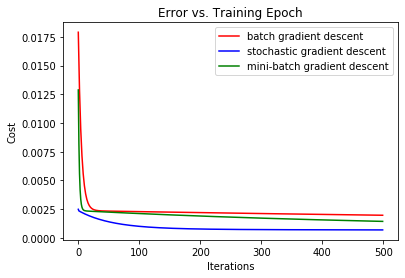

In [28]:
#plot the cost
fig, ax = plt.subplots()  
ax.plot(np.arange(max_iteration), cost, 'r')  
ax.plot(np.arange(max_iteration), s_cost, 'b')  
ax.plot(np.arange(max_iteration), mb_cost, 'g')  
ax.legend(loc='upper right', labels=['batch gradient descent', 'stochastic gradient descent', 'mini-batch gradient descent'])
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')  

plt.show()

### Visualize the Data

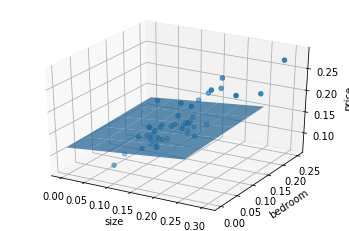

In [29]:
# Fixing random state for reproducibility
np.random.seed(19680801)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = X[:, 0]
ys = X[:, 1]
zs = Y
ax.scatter(xs, ys, zs)

ax.set_xlabel('size')
ax.set_ylabel('bedroom')
ax.set_zlabel('price')

x = y = np.arange(0, 0.3, 0.05)
xp, yp = np.meshgrid(x, y)
z = np.array([h(theta, np.array([[x,y]]))[0, 0] for x,y in zip(np.ravel(xp), np.ravel(yp))])
zp = z.reshape(xp.shape)

ax.plot_surface(xp, yp, zp, alpha=0.7)
    
plt.show()

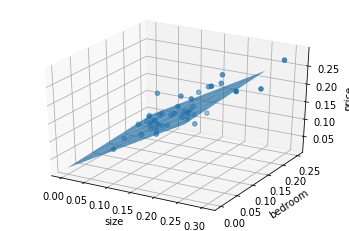

In [30]:
# Fixing random state for reproducibility
np.random.seed(19680801)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = X[:, 0]
ys = X[:, 1]
zs = Y
ax.scatter(xs, ys, zs)

ax.set_xlabel('size')
ax.set_ylabel('bedroom')
ax.set_zlabel('price')

x = y = np.arange(0, 0.3, 0.05)
xp, yp = np.meshgrid(x, y)
z = np.array([h(s_theta, np.array([[x,y]]))[0, 0] for x,y in zip(np.ravel(xp), np.ravel(yp))])
zp = z.reshape(xp.shape)

ax.plot_surface(xp, yp, zp, alpha=0.7)
    
plt.show()

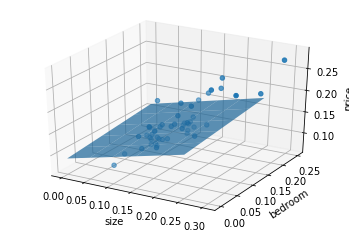

In [31]:
# Fixing random state for reproducibility
np.random.seed(19680801)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = y = np.arange(0, 0.3, 0.05)
xp, yp = np.meshgrid(x, y)
z = np.array([h(mb_theta, np.array([[x,y]]))[0, 0] for x,y in zip(np.ravel(xp), np.ravel(yp))])
zp = z.reshape(xp.shape)
ax.plot_surface(xp, yp, zp, alpha=0.7)

xs = X[:, 0]
ys = X[:, 1]
zs = Y
ax.scatter(xs, ys, zs)


ax.set_xlabel('size')
ax.set_ylabel('bedroom')
ax.set_zlabel('price')
    
plt.show()

Based on the losses and plots after 500 iterations through the dataset, which gradient descent method appears to yield the best predictions for this particular problem?

> Based on the loss, stochastic gradient descent yeild the best predictions.